In [1]:
from __future__ import division
import os
import time
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.generic_utils import get_custom_objects

import pandas as pd

from ops import *
from utils import *


Using TensorFlow backend.


In [2]:
class MNIST_PINE(object):
    model_name = "MNIST_PINE"     # name for checkpoint

    def __init__(self, sess, epoch, batch_size, dataset_name, checkpoint_dir):
        self.sess = sess
        self.dataset_name = dataset_name
        self.checkpoint_dir = checkpoint_dir
        self.epoch = epoch
        self.batch_size = batch_size

        if dataset_name == 'mnist':
            # parameters
            self.input_height = 28
            self.input_width = 28
            self.output_height = 28
            self.output_width = 28
      
            self.y_dim = 10        
            self.c_dim = 1

            # train
            self.learning_rate = 0.0001
            self.beta1 = 0.5

            # test
            self.sample_num = 64  
            self.len_discrete_code = 10

            # load mnist
            self.data_X, self.data_y = load_mnist(self.dataset_name)

            # get number of batches for a single epoch
            self.num_batches = len(self.data_X) // self.batch_size
            self.kcc = tf.keras.losses.CategoricalCrossentropy()
        else:
            raise NotImplementedError
            

    def interpreter(self, x, is_training=True, reuse=False):
        
        with tf.compat.v1.variable_scope("interpreter", reuse=reuse):

            net = tf.nn.relu(coinv2d(x, 64, 4, 4, 2, 2, name='int_conv1'))
            net = tf.reshape(net, [self.batch_size, -1])
            code = (linear(net, 32, scope='int_fc6')) # bn and relu are excluded since code is used in pullaway_loss
            net = tf.nn.relu(bn(linear(code, 64 * 14 * 14, scope='int_fc3'), is_training=is_training, scope='int_bn3'))
            net = tf.reshape(net, [self.batch_size, 14, 14, 64])
            out = tf.nn.sigmoid(deconv2d(net, [self.batch_size, 28, 28, 1], 4, 4, 2, 2, name='int_dc5'))

            # recon loss
            recon_error = tf.sqrt(2 * tf.nn.l2_loss(out - x)) / self.batch_size
            return out, recon_error, code

    def main_model(self, x, is_training=True, reuse=False):

        with tf.compat.v1.variable_scope("main_model", reuse=reuse):    

            net = lrelu(coinv2d(x, 64, 4, 4, 2, 2, name='mm_conv1'))
            net = lrelu(bn(coinv2d(net, 128, 4, 4, 2, 2, name='mm_conv2'), is_training=is_training, scope='mm_bn2'))
            net = tf.reshape(net, [self.batch_size, -1])
            net = lrelu(bn(linear(net, 1024, scope='mm_fc3'), is_training=is_training, scope='mm_bn3'))
            out_logit = linear(net, 10, scope='mm_fc4')
            out = tf.nn.softmax(out_logit)

            return out, out_logit
        
    def build_pine(self):
        # some parameters
        image_dims = [self.input_height, self.input_width, self.c_dim]
        bs = self.batch_size

        """ Graph Input """
        # images
        self.inputs = tf.compat.v1.placeholder(tf.float32, [bs] + image_dims, name='real_images')

        # labels
        self.y = tf.compat.v1.placeholder(tf.float32, [bs, self.y_dim], name='y')


        """ Loss Function """


        tafsir, tafsir_err, code = self.interpreter(self.inputs, is_training=True)
        out_tafsir, out_logit_tafsir = self.main_model(tafsir, is_training=True)
        out_real, out_logit_real = self.main_model(self.inputs, is_training=True, reuse= True)        



        self.mm_loss = self.kcc(out_real,self.y)
        out_sqrt = tf.keras.backend.sqrt(tafsir)
        sumi = tf.keras.backend.sum(out_sqrt)**2
        self.int_loss = 10000*tafsir_err + 10000*self.kcc(out_tafsir, self.y) + sumi / 1000000 


        """ Training """

        t_vars = tf.compat.v1.trainable_variables()
        int_vars = [var for var in t_vars if 'int_' in var.name]
        mm_vars = [var for var in t_vars if 'mm_' in var.name]
  

        # optimizers
        with tf.control_dependencies(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)):

            self.int_optim = tf.compat.v1.train.AdamOptimizer(self.learning_rate * 5, beta1=self.beta1) \
            .minimize(self.int_loss, var_list=int_vars)
            self.mm_optim = tf.compat.v1.train.AdamOptimizer(self.learning_rate * 5, beta1=self.beta1) \
            .minimize(self.mm_loss, var_list=mm_vars)


        """" Testing """
        # for test
        self.tafsir_images = self.interpreter(self.inputs, is_training=False, reuse=True)
        """ Summary """
        int_loss_sum = tf.compat.v1.summary.scalar("int_loss", self.int_loss)
        mm_loss_sum = tf.compat.v1.summary.scalar("mm_loss", self.mm_loss)

        self.int_sum = tf.compat.v1.summary.merge([int_loss_sum])
        self.mm_sum = tf.compat.v1.summary.merge([mm_loss_sum])       
    def train(self):

        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.test_codes = self.data_y[0:self.batch_size]
        self.sample_input = self.data_X[0:self.batch_size]

        # saver to save model
        self.saver = tf.compat.v1.train.Saver()

        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [i] OK. I've found it.")
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [i] NOTHING FOUND TO LOAD!")

        # loop for epoch
        start_time = time.time()
        for epoch in range(start_epoch, self.epoch):

            # get batch data
            for idx in range(start_batch_id, self.num_batches):
                batch_images = self.data_X[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_codes = self.data_y[idx * self.batch_size:(idx + 1) * self.batch_size]


                #update Interpreter
                _, summary_str, int_loss = self.sess.run([self.int_optim, self.int_sum, self.int_loss],
                                                       feed_dict={self.inputs: batch_images, self.y: batch_codes})

                # update Main Model
                _, summary_str_mm, mm_loss = self.sess.run(
                    [self.mm_optim, self.mm_sum, self.mm_loss],
                    feed_dict={self.y: batch_codes, self.inputs: batch_images})


                # display training status
                counter += 1
                print("Epoch: [%2d] [%4d/%4d] time: %4.4f, int_loss: %.8f,mm_loss: %.8f" \
                      % (epoch, idx, self.num_batches, time.time() - start_time, int_loss, mm_loss))


            start_batch_id = 0

            # save model
            self.save(self.checkpoint_dir, counter)

        # save model for final step
        self.save(self.checkpoint_dir, counter)

    @property
    def model_dir(self):
        return "{}_{}".format(
            self.model_name, self.dataset_name)

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,os.path.join(checkpoint_dir, self.model_name+'.model'), global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [i] Wait a sec...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
            print(" [i] OK. Reading Completed! {}".format(ckpt_name))
            return True, counter
        else:
            print(" [i] NO CHECKPOINTS FOUND!")
            return False, 0
    def just_load(self, tobe_tafsired):
        
        # initialize all variables
        tf.compat.v1.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.test_codes = self.data_y[0:self.batch_size]
        self.sample_input = self.data_X[0:self.batch_size]


        # saver to save model
        self.saver = tf.compat.v1.train.Saver()


        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [i] Loading done!")
        samples, recon_error, code = self.sess.run(self.tafsir_images, feed_dict={self.inputs: tobe_tafsired})
        return samples
    

In [3]:
samples = []
X_test = pd.read_csv("test.csv")
X_test = X_test/255
X_test = X_test.values.reshape(-1,28,28,1)
tests = X_test[0:64]
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as sess:
# open session
    pine = MNIST_PINE(sess,
                epoch=5,
                batch_size=64,
                dataset_name='mnist',
                checkpoint_dir= 'checkpoint')

    # build graph
    pine.build_pine()
    # initialize all variables
    pine.train()
    interprets = pine.just_load(tests)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


 [i] Wait a sec...
 [i] NO CHECKPOINTS FOUND!
 [i] NOTHING FOUND TO LOAD!
Epoch: [ 0] [   0/1093] time: 0.4354, int_loss: 163809.64062500,mm_loss: 14.62749672
Epoch: [ 0] [   1/1093] time: 0.5408, int_loss: 149224.20312500,mm_loss: 10.30598068
Epoch: [ 0] [   2/1093] time: 0.6433, int_loss: 129726.28906250,mm_loss: 7.82075787
Epoch: [ 0] [   3/1093] time: 0.7596, int_loss: 124886.13281250,mm_loss: 7.01944065
Epoch: [ 0] [   4/1093] time: 0.8615, int_loss: 109366.16406250,mm_loss: 7.42529821
Epoch: [ 0] [   5/1093] time: 0.9803, int_loss: 87373.65625000,mm_loss: 3.86201215
Epoch: [ 0] [   6/1093] time: 1.0830, int_loss: 88564.75781250,mm_loss: 3.96485019
Epoch: [ 0] [   7/1093] time: 1.2004, int_loss: 65254.06640625,mm_loss: 3.45392537
Epoch: [ 0] [   8/1093] time: 1.3172, int_loss: 74915.33593750,mm_loss: 4.04849625
Epoch: [ 0] [   9/1093] time: 1.4298, int_loss: 59347.56640625,mm_loss: 3.57578754
Epoch: [ 0] [  10/1093] time: 1.5360, int_loss: 72315.14062500,mm_loss: 5.19145107
Epoch:

Epoch: [ 0] [  98/1093] time: 11.7592, int_loss: 30691.91406250,mm_loss: 0.67317939
Epoch: [ 0] [  99/1093] time: 11.8728, int_loss: 32327.32812500,mm_loss: 1.14613295
Epoch: [ 0] [ 100/1093] time: 11.9776, int_loss: 30871.45117188,mm_loss: 0.92988116
Epoch: [ 0] [ 101/1093] time: 12.1051, int_loss: 33277.34765625,mm_loss: 1.18786144
Epoch: [ 0] [ 102/1093] time: 12.2426, int_loss: 42531.96484375,mm_loss: 2.18511057
Epoch: [ 0] [ 103/1093] time: 12.3586, int_loss: 40309.03906250,mm_loss: 2.29912305
Epoch: [ 0] [ 104/1093] time: 12.4726, int_loss: 35580.92578125,mm_loss: 1.94086576
Epoch: [ 0] [ 105/1093] time: 12.5898, int_loss: 32680.87695312,mm_loss: 0.94874346
Epoch: [ 0] [ 106/1093] time: 12.7103, int_loss: 22791.55664062,mm_loss: 0.15692368
Epoch: [ 0] [ 107/1093] time: 12.8292, int_loss: 40160.30468750,mm_loss: 1.25079882
Epoch: [ 0] [ 108/1093] time: 12.9499, int_loss: 26742.25781250,mm_loss: 0.56967831
Epoch: [ 0] [ 109/1093] time: 13.0718, int_loss: 27917.41406250,mm_loss: 1.1

Epoch: [ 0] [ 196/1093] time: 22.5188, int_loss: 27469.37109375,mm_loss: 0.83596539
Epoch: [ 0] [ 197/1093] time: 22.6290, int_loss: 22628.05273438,mm_loss: 0.77336359
Epoch: [ 0] [ 198/1093] time: 22.7310, int_loss: 23524.53515625,mm_loss: 0.21646006
Epoch: [ 0] [ 199/1093] time: 22.8402, int_loss: 39072.42968750,mm_loss: 1.65526938
Epoch: [ 0] [ 200/1093] time: 22.9522, int_loss: 22870.18359375,mm_loss: 0.83994466
Epoch: [ 0] [ 201/1093] time: 23.0694, int_loss: 24364.56445312,mm_loss: 0.68487847
Epoch: [ 0] [ 202/1093] time: 23.1875, int_loss: 28199.42968750,mm_loss: 1.35725188
Epoch: [ 0] [ 203/1093] time: 23.2892, int_loss: 26283.09960938,mm_loss: 1.14923441
Epoch: [ 0] [ 204/1093] time: 23.3944, int_loss: 20889.98828125,mm_loss: 0.73716033
Epoch: [ 0] [ 205/1093] time: 23.5024, int_loss: 19496.68554688,mm_loss: 0.14224549
Epoch: [ 0] [ 206/1093] time: 23.6069, int_loss: 17782.05468750,mm_loss: 0.52321422
Epoch: [ 0] [ 207/1093] time: 23.7133, int_loss: 35043.00390625,mm_loss: 1.8

Epoch: [ 0] [ 294/1093] time: 32.9710, int_loss: 32112.90039062,mm_loss: 0.84431422
Epoch: [ 0] [ 295/1093] time: 33.0771, int_loss: 23268.58203125,mm_loss: 1.38189554
Epoch: [ 0] [ 296/1093] time: 33.1900, int_loss: 26366.21875000,mm_loss: 0.76999855
Epoch: [ 0] [ 297/1093] time: 33.3034, int_loss: 15766.12988281,mm_loss: 0.54356837
Epoch: [ 0] [ 298/1093] time: 33.4160, int_loss: 27552.14062500,mm_loss: 1.40833306
Epoch: [ 0] [ 299/1093] time: 33.5226, int_loss: 23419.17968750,mm_loss: 0.49308419
Epoch: [ 0] [ 300/1093] time: 33.6278, int_loss: 19948.34570312,mm_loss: 0.57148695
Epoch: [ 0] [ 301/1093] time: 33.7351, int_loss: 24354.93359375,mm_loss: 0.65517414
Epoch: [ 0] [ 302/1093] time: 33.8474, int_loss: 19130.07812500,mm_loss: 0.73916429
Epoch: [ 0] [ 303/1093] time: 33.9532, int_loss: 17241.37109375,mm_loss: 0.71127892
Epoch: [ 0] [ 304/1093] time: 34.0609, int_loss: 14106.69726562,mm_loss: 0.27711663
Epoch: [ 0] [ 305/1093] time: 34.1682, int_loss: 20631.01171875,mm_loss: 0.8

Epoch: [ 0] [ 392/1093] time: 43.4093, int_loss: 20093.85742188,mm_loss: 0.36787140
Epoch: [ 0] [ 393/1093] time: 43.5147, int_loss: 16922.05859375,mm_loss: 0.39462721
Epoch: [ 0] [ 394/1093] time: 43.6173, int_loss: 18331.36328125,mm_loss: 0.32640171
Epoch: [ 0] [ 395/1093] time: 43.7329, int_loss: 27355.74414062,mm_loss: 1.23334992
Epoch: [ 0] [ 396/1093] time: 43.8458, int_loss: 16929.57812500,mm_loss: 0.67137331
Epoch: [ 0] [ 397/1093] time: 43.9562, int_loss: 20232.66406250,mm_loss: 0.65962148
Epoch: [ 0] [ 398/1093] time: 44.0618, int_loss: 20255.73046875,mm_loss: 0.34961602
Epoch: [ 0] [ 399/1093] time: 44.1689, int_loss: 20985.58593750,mm_loss: 0.27610829
Epoch: [ 0] [ 400/1093] time: 44.2731, int_loss: 11830.91308594,mm_loss: 0.43280825
Epoch: [ 0] [ 401/1093] time: 44.3812, int_loss: 17061.12500000,mm_loss: 0.39165145
Epoch: [ 0] [ 402/1093] time: 44.4875, int_loss: 22309.33398438,mm_loss: 1.01543474
Epoch: [ 0] [ 403/1093] time: 44.5967, int_loss: 24048.09570312,mm_loss: 0.7

Epoch: [ 0] [ 490/1093] time: 53.8972, int_loss: 18118.83789062,mm_loss: 0.21786928
Epoch: [ 0] [ 491/1093] time: 54.0085, int_loss: 25248.76367188,mm_loss: 0.86006838
Epoch: [ 0] [ 492/1093] time: 54.1123, int_loss: 21368.43750000,mm_loss: 0.50503141
Epoch: [ 0] [ 493/1093] time: 54.2252, int_loss: 19201.25390625,mm_loss: 0.38457128
Epoch: [ 0] [ 494/1093] time: 54.3373, int_loss: 16663.13085938,mm_loss: 0.12427752
Epoch: [ 0] [ 495/1093] time: 54.4490, int_loss: 17697.87695312,mm_loss: 0.74676776
Epoch: [ 0] [ 496/1093] time: 54.5516, int_loss: 17266.69531250,mm_loss: 0.76414520
Epoch: [ 0] [ 497/1093] time: 54.6586, int_loss: 22684.62500000,mm_loss: 0.67019784
Epoch: [ 0] [ 498/1093] time: 54.7623, int_loss: 15636.23925781,mm_loss: 0.35368896
Epoch: [ 0] [ 499/1093] time: 54.8703, int_loss: 11299.20898438,mm_loss: 0.19698806
Epoch: [ 0] [ 500/1093] time: 54.9723, int_loss: 23519.64257812,mm_loss: 1.18842876
Epoch: [ 0] [ 501/1093] time: 55.0838, int_loss: 21245.04492188,mm_loss: 0.5

Epoch: [ 0] [ 588/1093] time: 64.3417, int_loss: 22296.57226562,mm_loss: 0.38362592
Epoch: [ 0] [ 589/1093] time: 64.4530, int_loss: 19711.93750000,mm_loss: 0.55590177
Epoch: [ 0] [ 590/1093] time: 64.5541, int_loss: 18459.52929688,mm_loss: 0.60894334
Epoch: [ 0] [ 591/1093] time: 64.6639, int_loss: 20396.86718750,mm_loss: 0.96360540
Epoch: [ 0] [ 592/1093] time: 64.7753, int_loss: 14619.77929688,mm_loss: 0.03990938
Epoch: [ 0] [ 593/1093] time: 64.8872, int_loss: 20915.97460938,mm_loss: 0.54619092
Epoch: [ 0] [ 594/1093] time: 64.9900, int_loss: 20519.30859375,mm_loss: 0.64159888
Epoch: [ 0] [ 595/1093] time: 65.0990, int_loss: 17308.11328125,mm_loss: 0.54275727
Epoch: [ 0] [ 596/1093] time: 65.2070, int_loss: 12725.58789062,mm_loss: 0.30991659
Epoch: [ 0] [ 597/1093] time: 65.3116, int_loss: 24902.98242188,mm_loss: 0.43062782
Epoch: [ 0] [ 598/1093] time: 65.4137, int_loss: 17864.57031250,mm_loss: 0.68384576
Epoch: [ 0] [ 599/1093] time: 65.5218, int_loss: 26468.02148438,mm_loss: 0.5

Epoch: [ 0] [ 686/1093] time: 74.8324, int_loss: 11202.15527344,mm_loss: 0.42716879
Epoch: [ 0] [ 687/1093] time: 74.9394, int_loss: 22058.87500000,mm_loss: 0.77109683
Epoch: [ 0] [ 688/1093] time: 75.0451, int_loss: 19066.79492188,mm_loss: 0.24550936
Epoch: [ 0] [ 689/1093] time: 75.1636, int_loss: 17626.08398438,mm_loss: 0.62662131
Epoch: [ 0] [ 690/1093] time: 75.2767, int_loss: 16485.59179688,mm_loss: 0.30468825
Epoch: [ 0] [ 691/1093] time: 75.3874, int_loss: 21293.06640625,mm_loss: 0.47660959
Epoch: [ 0] [ 692/1093] time: 75.4902, int_loss: 17759.39453125,mm_loss: 0.50123215
Epoch: [ 0] [ 693/1093] time: 75.5978, int_loss: 18996.43945312,mm_loss: 0.46986887
Epoch: [ 0] [ 694/1093] time: 75.7059, int_loss: 18888.20117188,mm_loss: 0.63712013
Epoch: [ 0] [ 695/1093] time: 75.8144, int_loss: 19741.90625000,mm_loss: 0.58963180
Epoch: [ 0] [ 696/1093] time: 75.9209, int_loss: 13365.53515625,mm_loss: 0.18713847
Epoch: [ 0] [ 697/1093] time: 76.0299, int_loss: 14032.72265625,mm_loss: 0.1

Epoch: [ 0] [ 784/1093] time: 85.2880, int_loss: 16543.73437500,mm_loss: 0.31744888
Epoch: [ 0] [ 785/1093] time: 85.3951, int_loss: 11785.40136719,mm_loss: 0.31691045
Epoch: [ 0] [ 786/1093] time: 85.4969, int_loss: 15333.60058594,mm_loss: 0.33575508
Epoch: [ 0] [ 787/1093] time: 85.6106, int_loss: 18364.90039062,mm_loss: 0.61570495
Epoch: [ 0] [ 788/1093] time: 85.7226, int_loss: 22485.54101562,mm_loss: 0.29997835
Epoch: [ 0] [ 789/1093] time: 85.8368, int_loss: 13445.35253906,mm_loss: 0.11416869
Epoch: [ 0] [ 790/1093] time: 85.9401, int_loss: 24795.69335938,mm_loss: 0.90607047
Epoch: [ 0] [ 791/1093] time: 86.0465, int_loss: 18575.62695312,mm_loss: 0.58153343
Epoch: [ 0] [ 792/1093] time: 86.1603, int_loss: 28365.25195312,mm_loss: 1.15657711
Epoch: [ 0] [ 793/1093] time: 86.2686, int_loss: 15640.58105469,mm_loss: 0.27425379
Epoch: [ 0] [ 794/1093] time: 86.3718, int_loss: 20540.45312500,mm_loss: 0.29785320
Epoch: [ 0] [ 795/1093] time: 86.4806, int_loss: 22274.66406250,mm_loss: 0.4

Epoch: [ 0] [ 882/1093] time: 95.7859, int_loss: 17181.36718750,mm_loss: 0.42048088
Epoch: [ 0] [ 883/1093] time: 95.8914, int_loss: 22236.60156250,mm_loss: 0.62921911
Epoch: [ 0] [ 884/1093] time: 95.9938, int_loss: 20281.43359375,mm_loss: 0.38088208
Epoch: [ 0] [ 885/1093] time: 96.1024, int_loss: 15663.36914062,mm_loss: 0.18165652
Epoch: [ 0] [ 886/1093] time: 96.2118, int_loss: 13031.25585938,mm_loss: 0.71515596
Epoch: [ 0] [ 887/1093] time: 96.3225, int_loss: 18634.02343750,mm_loss: 0.47940379
Epoch: [ 0] [ 888/1093] time: 96.4287, int_loss: 13296.89257812,mm_loss: 0.11382915
Epoch: [ 0] [ 889/1093] time: 96.5371, int_loss: 13836.60644531,mm_loss: 0.26220059
Epoch: [ 0] [ 890/1093] time: 96.6456, int_loss: 12669.28515625,mm_loss: 0.24142580
Epoch: [ 0] [ 891/1093] time: 96.7552, int_loss: 20212.37695312,mm_loss: 0.25233746
Epoch: [ 0] [ 892/1093] time: 96.8606, int_loss: 13075.00781250,mm_loss: 0.24510697
Epoch: [ 0] [ 893/1093] time: 96.9668, int_loss: 23025.06250000,mm_loss: 0.5

Epoch: [ 0] [ 980/1093] time: 106.2810, int_loss: 17110.87304688,mm_loss: 0.72149587
Epoch: [ 0] [ 981/1093] time: 106.3877, int_loss: 21186.99609375,mm_loss: 0.31447464
Epoch: [ 0] [ 982/1093] time: 106.4927, int_loss: 16799.17773438,mm_loss: 0.35060847
Epoch: [ 0] [ 983/1093] time: 106.6018, int_loss: 17296.88281250,mm_loss: 0.04217403
Epoch: [ 0] [ 984/1093] time: 106.7137, int_loss: 19748.55078125,mm_loss: 0.80768102
Epoch: [ 0] [ 985/1093] time: 106.8258, int_loss: 15184.48535156,mm_loss: 0.28383160
Epoch: [ 0] [ 986/1093] time: 106.9338, int_loss: 22791.25390625,mm_loss: 0.56642252
Epoch: [ 0] [ 987/1093] time: 107.0422, int_loss: 25831.49804688,mm_loss: 0.35155463
Epoch: [ 0] [ 988/1093] time: 107.1436, int_loss: 11277.09277344,mm_loss: 0.02068650
Epoch: [ 0] [ 989/1093] time: 107.2518, int_loss: 10512.35546875,mm_loss: 0.22766937
Epoch: [ 0] [ 990/1093] time: 107.3544, int_loss: 18324.89062500,mm_loss: 0.49570435
Epoch: [ 0] [ 991/1093] time: 107.4628, int_loss: 11583.97558594,

Epoch: [ 0] [1078/1093] time: 116.8054, int_loss: 12559.29296875,mm_loss: 0.02703240
Epoch: [ 0] [1079/1093] time: 116.9220, int_loss: 16444.57812500,mm_loss: 0.04194793
Epoch: [ 0] [1080/1093] time: 117.0268, int_loss: 16919.69140625,mm_loss: 0.82612914
Epoch: [ 0] [1081/1093] time: 117.1402, int_loss: 14526.64746094,mm_loss: 0.50544125
Epoch: [ 0] [1082/1093] time: 117.2562, int_loss: 21999.42187500,mm_loss: 0.12770781
Epoch: [ 0] [1083/1093] time: 117.3676, int_loss: 19997.92578125,mm_loss: 0.76857853
Epoch: [ 0] [1084/1093] time: 117.4706, int_loss: 13503.95117188,mm_loss: 0.16372073
Epoch: [ 0] [1085/1093] time: 117.5783, int_loss: 24117.57226562,mm_loss: 0.51732862
Epoch: [ 0] [1086/1093] time: 117.6839, int_loss: 13706.47167969,mm_loss: 0.27341968
Epoch: [ 0] [1087/1093] time: 117.7912, int_loss: 20755.20117188,mm_loss: 0.43722153
Epoch: [ 0] [1088/1093] time: 117.8933, int_loss: 11169.87890625,mm_loss: 0.15531074
Epoch: [ 0] [1089/1093] time: 118.0017, int_loss: 10834.85058594,

Epoch: [ 1] [  82/1093] time: 127.3519, int_loss: 12890.33203125,mm_loss: 0.06733236
Epoch: [ 1] [  83/1093] time: 127.4599, int_loss: 14664.30175781,mm_loss: 0.48667845
Epoch: [ 1] [  84/1093] time: 127.5653, int_loss: 17680.09960938,mm_loss: 0.75157928
Epoch: [ 1] [  85/1093] time: 127.6796, int_loss: 18444.10937500,mm_loss: 0.41815710
Epoch: [ 1] [  86/1093] time: 127.7921, int_loss: 14468.34960938,mm_loss: 0.02794248
Epoch: [ 1] [  87/1093] time: 127.9022, int_loss: 13176.35058594,mm_loss: 0.05325617
Epoch: [ 1] [  88/1093] time: 128.0058, int_loss: 13596.58789062,mm_loss: 0.15297388
Epoch: [ 1] [  89/1093] time: 128.1143, int_loss: 19349.12500000,mm_loss: 0.18435723
Epoch: [ 1] [  90/1093] time: 128.2177, int_loss: 15003.80859375,mm_loss: 0.47467369
Epoch: [ 1] [  91/1093] time: 128.3275, int_loss: 20074.14843750,mm_loss: 0.86815441
Epoch: [ 1] [  92/1093] time: 128.4348, int_loss: 22606.92968750,mm_loss: 0.74327731
Epoch: [ 1] [  93/1093] time: 128.5439, int_loss: 15901.86816406,

Epoch: [ 1] [ 180/1093] time: 137.8402, int_loss: 21045.55664062,mm_loss: 0.38771954
Epoch: [ 1] [ 181/1093] time: 137.9521, int_loss: 12427.36523438,mm_loss: 0.08799560
Epoch: [ 1] [ 182/1093] time: 138.0577, int_loss: 21453.85156250,mm_loss: 0.97356761
Epoch: [ 1] [ 183/1093] time: 138.1717, int_loss: 14681.92578125,mm_loss: 0.25935367
Epoch: [ 1] [ 184/1093] time: 138.2854, int_loss: 18548.99218750,mm_loss: 0.30219498
Epoch: [ 1] [ 185/1093] time: 138.3968, int_loss: 16664.59960938,mm_loss: 0.71436334
Epoch: [ 1] [ 186/1093] time: 138.5002, int_loss: 12607.34765625,mm_loss: 0.21339919
Epoch: [ 1] [ 187/1093] time: 138.6082, int_loss: 11776.39941406,mm_loss: 0.00127773
Epoch: [ 1] [ 188/1093] time: 138.7115, int_loss: 10656.30371094,mm_loss: 0.01497829
Epoch: [ 1] [ 189/1093] time: 138.8252, int_loss: 17951.01953125,mm_loss: 0.59804207
Epoch: [ 1] [ 190/1093] time: 138.9289, int_loss: 16889.50195312,mm_loss: 0.35972950
Epoch: [ 1] [ 191/1093] time: 139.0362, int_loss: 16920.04492188,

Epoch: [ 1] [ 278/1093] time: 148.3462, int_loss: 17527.18164062,mm_loss: 0.23185003
Epoch: [ 1] [ 279/1093] time: 148.4552, int_loss: 16861.95312500,mm_loss: 0.30851540
Epoch: [ 1] [ 280/1093] time: 148.5586, int_loss: 10084.35742188,mm_loss: 0.02855563
Epoch: [ 1] [ 281/1093] time: 148.6779, int_loss: 12786.47460938,mm_loss: 0.29304561
Epoch: [ 1] [ 282/1093] time: 148.7903, int_loss: 17422.58007812,mm_loss: 0.27006277
Epoch: [ 1] [ 283/1093] time: 148.8989, int_loss: 13784.66406250,mm_loss: 0.15617959
Epoch: [ 1] [ 284/1093] time: 149.0015, int_loss: 15261.09960938,mm_loss: 0.37465328
Epoch: [ 1] [ 285/1093] time: 149.1115, int_loss: 21467.18164062,mm_loss: 1.21238720
Epoch: [ 1] [ 286/1093] time: 149.2180, int_loss: 17504.12304688,mm_loss: 0.69298220
Epoch: [ 1] [ 287/1093] time: 149.3271, int_loss: 18168.48437500,mm_loss: 0.69011116
Epoch: [ 1] [ 288/1093] time: 149.4368, int_loss: 11370.19042969,mm_loss: 0.07595725
Epoch: [ 1] [ 289/1093] time: 149.5484, int_loss: 14132.69726562,

Epoch: [ 1] [ 376/1093] time: 158.9106, int_loss: 20100.16992188,mm_loss: 0.79618514
Epoch: [ 1] [ 377/1093] time: 159.0176, int_loss: 14308.73144531,mm_loss: 0.13355394
Epoch: [ 1] [ 378/1093] time: 159.1244, int_loss: 17491.75585938,mm_loss: 1.04540014
Epoch: [ 1] [ 379/1093] time: 159.2417, int_loss: 16762.78906250,mm_loss: 0.38453031
Epoch: [ 1] [ 380/1093] time: 159.3575, int_loss: 9792.92285156,mm_loss: 0.28959575
Epoch: [ 1] [ 381/1093] time: 159.4674, int_loss: 14777.13281250,mm_loss: 0.24780349
Epoch: [ 1] [ 382/1093] time: 159.5746, int_loss: 13959.27441406,mm_loss: 0.07982419
Epoch: [ 1] [ 383/1093] time: 159.6863, int_loss: 17512.15234375,mm_loss: 0.55659020
Epoch: [ 1] [ 384/1093] time: 159.7916, int_loss: 18641.22265625,mm_loss: 0.72075558
Epoch: [ 1] [ 385/1093] time: 159.9002, int_loss: 9840.57324219,mm_loss: 0.01536782
Epoch: [ 1] [ 386/1093] time: 160.0051, int_loss: 14686.13574219,mm_loss: 0.22792354
Epoch: [ 1] [ 387/1093] time: 160.1181, int_loss: 19871.40234375,mm

Epoch: [ 1] [ 474/1093] time: 169.4484, int_loss: 17549.03320312,mm_loss: 0.69610709
Epoch: [ 1] [ 475/1093] time: 169.5585, int_loss: 21233.81445312,mm_loss: 0.29760650
Epoch: [ 1] [ 476/1093] time: 169.6623, int_loss: 10176.20019531,mm_loss: 0.01145179
Epoch: [ 1] [ 477/1093] time: 169.7726, int_loss: 12639.18554688,mm_loss: 0.39476398
Epoch: [ 1] [ 478/1093] time: 169.8866, int_loss: 14283.59570312,mm_loss: 0.15909865
Epoch: [ 1] [ 479/1093] time: 169.9960, int_loss: 20236.82226562,mm_loss: 0.60123676
Epoch: [ 1] [ 480/1093] time: 170.0990, int_loss: 14851.95507812,mm_loss: 0.39608711
Epoch: [ 1] [ 481/1093] time: 170.2172, int_loss: 20364.07031250,mm_loss: 0.65866756
Epoch: [ 1] [ 482/1093] time: 170.3222, int_loss: 12567.25000000,mm_loss: 0.54583466
Epoch: [ 1] [ 483/1093] time: 170.4293, int_loss: 19235.61328125,mm_loss: 0.34321910
Epoch: [ 1] [ 484/1093] time: 170.5360, int_loss: 13605.44628906,mm_loss: 0.13436230
Epoch: [ 1] [ 485/1093] time: 170.6424, int_loss: 14729.39355469,

Epoch: [ 1] [ 572/1093] time: 179.9230, int_loss: 16999.08789062,mm_loss: 0.75589508
Epoch: [ 1] [ 573/1093] time: 180.0320, int_loss: 9697.88574219,mm_loss: 0.00147093
Epoch: [ 1] [ 574/1093] time: 180.1396, int_loss: 14312.90820312,mm_loss: 0.68454921
Epoch: [ 1] [ 575/1093] time: 180.2590, int_loss: 14561.59472656,mm_loss: 0.01063165
Epoch: [ 1] [ 576/1093] time: 180.3675, int_loss: 16587.64062500,mm_loss: 0.13062203
Epoch: [ 1] [ 577/1093] time: 180.4754, int_loss: 11098.72070312,mm_loss: 0.28315961
Epoch: [ 1] [ 578/1093] time: 180.5793, int_loss: 12199.90917969,mm_loss: 0.00769519
Epoch: [ 1] [ 579/1093] time: 180.6905, int_loss: 14146.89062500,mm_loss: 0.02333006
Epoch: [ 1] [ 580/1093] time: 180.7925, int_loss: 14548.48046875,mm_loss: 0.06039122
Epoch: [ 1] [ 581/1093] time: 180.8995, int_loss: 17224.72070312,mm_loss: 0.61246985
Epoch: [ 1] [ 582/1093] time: 181.0017, int_loss: 17953.57031250,mm_loss: 0.59334153
Epoch: [ 1] [ 583/1093] time: 181.1137, int_loss: 17584.32812500,m

Epoch: [ 1] [ 670/1093] time: 190.4042, int_loss: 14336.80761719,mm_loss: 0.01933477
Epoch: [ 1] [ 671/1093] time: 190.5105, int_loss: 14115.53710938,mm_loss: 0.06809196
Epoch: [ 1] [ 672/1093] time: 190.6183, int_loss: 16598.40039062,mm_loss: 0.27186495
Epoch: [ 1] [ 673/1093] time: 190.7307, int_loss: 12975.99609375,mm_loss: 0.08893526
Epoch: [ 1] [ 674/1093] time: 190.8412, int_loss: 12669.13085938,mm_loss: 0.31146377
Epoch: [ 1] [ 675/1093] time: 190.9511, int_loss: 20113.87304688,mm_loss: 0.49541330
Epoch: [ 1] [ 676/1093] time: 191.0569, int_loss: 17791.75976562,mm_loss: 0.34357849
Epoch: [ 1] [ 677/1093] time: 191.1653, int_loss: 13459.49511719,mm_loss: 0.25914261
Epoch: [ 1] [ 678/1093] time: 191.2665, int_loss: 13920.76074219,mm_loss: 0.25696996
Epoch: [ 1] [ 679/1093] time: 191.3728, int_loss: 14707.78906250,mm_loss: 0.78046477
Epoch: [ 1] [ 680/1093] time: 191.4752, int_loss: 16869.35937500,mm_loss: 0.16948439
Epoch: [ 1] [ 681/1093] time: 191.5831, int_loss: 11772.09570312,

Epoch: [ 1] [ 768/1093] time: 200.8728, int_loss: 13965.16992188,mm_loss: 0.27175486
Epoch: [ 1] [ 769/1093] time: 200.9828, int_loss: 22102.43554688,mm_loss: 0.26596847
Epoch: [ 1] [ 770/1093] time: 201.0865, int_loss: 13767.58300781,mm_loss: 0.03254015
Epoch: [ 1] [ 771/1093] time: 201.2005, int_loss: 11033.98437500,mm_loss: 0.00138994
Epoch: [ 1] [ 772/1093] time: 201.3153, int_loss: 10430.64746094,mm_loss: 0.08994348
Epoch: [ 1] [ 773/1093] time: 201.4253, int_loss: 16745.90625000,mm_loss: 0.28161848
Epoch: [ 1] [ 774/1093] time: 201.5294, int_loss: 17029.26562500,mm_loss: 0.50993770
Epoch: [ 1] [ 775/1093] time: 201.6355, int_loss: 14569.87402344,mm_loss: 0.27051938
Epoch: [ 1] [ 776/1093] time: 201.7416, int_loss: 15923.87500000,mm_loss: 0.86725283
Epoch: [ 1] [ 777/1093] time: 201.8487, int_loss: 12360.24902344,mm_loss: 0.05799500
Epoch: [ 1] [ 778/1093] time: 201.9545, int_loss: 14313.24218750,mm_loss: 0.25078627
Epoch: [ 1] [ 779/1093] time: 202.0611, int_loss: 10792.67382812,

Epoch: [ 1] [ 866/1093] time: 211.3630, int_loss: 15016.91113281,mm_loss: 0.49366942
Epoch: [ 1] [ 867/1093] time: 211.4741, int_loss: 19606.94140625,mm_loss: 0.48095554
Epoch: [ 1] [ 868/1093] time: 211.5836, int_loss: 14597.41699219,mm_loss: 0.51785105
Epoch: [ 1] [ 869/1093] time: 211.6949, int_loss: 17516.58593750,mm_loss: 1.07895851
Epoch: [ 1] [ 870/1093] time: 211.8095, int_loss: 15016.37011719,mm_loss: 0.04781300
Epoch: [ 1] [ 871/1093] time: 211.9221, int_loss: 9300.55273438,mm_loss: 0.25759122
Epoch: [ 1] [ 872/1093] time: 212.0274, int_loss: 17045.23828125,mm_loss: 0.33516529
Epoch: [ 1] [ 873/1093] time: 212.1367, int_loss: 22467.83984375,mm_loss: 0.41428268
Epoch: [ 1] [ 874/1093] time: 212.2418, int_loss: 18932.95312500,mm_loss: 0.79905105
Epoch: [ 1] [ 875/1093] time: 212.3480, int_loss: 14141.43261719,mm_loss: 0.24422549
Epoch: [ 1] [ 876/1093] time: 212.4523, int_loss: 10494.04589844,mm_loss: 0.23368298
Epoch: [ 1] [ 877/1093] time: 212.5640, int_loss: 11766.93554688,m

Epoch: [ 1] [ 964/1093] time: 221.8807, int_loss: 15613.90722656,mm_loss: 0.27813044
Epoch: [ 1] [ 965/1093] time: 221.9909, int_loss: 15481.39453125,mm_loss: 0.04586633
Epoch: [ 1] [ 966/1093] time: 222.0965, int_loss: 16114.05175781,mm_loss: 0.60610813
Epoch: [ 1] [ 967/1093] time: 222.2087, int_loss: 14567.70800781,mm_loss: 0.35864449
Epoch: [ 1] [ 968/1093] time: 222.3289, int_loss: 23820.00585938,mm_loss: 0.79521644
Epoch: [ 1] [ 969/1093] time: 222.4426, int_loss: 13574.43066406,mm_loss: 0.42443755
Epoch: [ 1] [ 970/1093] time: 222.5454, int_loss: 19677.79882812,mm_loss: 0.75233448
Epoch: [ 1] [ 971/1093] time: 222.6517, int_loss: 13112.37011719,mm_loss: 0.02682041
Epoch: [ 1] [ 972/1093] time: 222.7550, int_loss: 9611.12890625,mm_loss: 0.02141286
Epoch: [ 1] [ 973/1093] time: 222.8635, int_loss: 13786.06738281,mm_loss: 0.21134345
Epoch: [ 1] [ 974/1093] time: 222.9686, int_loss: 12200.81152344,mm_loss: 0.01351819
Epoch: [ 1] [ 975/1093] time: 223.0775, int_loss: 17764.41796875,m

Epoch: [ 1] [1062/1093] time: 232.3788, int_loss: 14213.36914062,mm_loss: 0.22190838
Epoch: [ 1] [1063/1093] time: 232.4844, int_loss: 11809.93750000,mm_loss: 0.28446484
Epoch: [ 1] [1064/1093] time: 232.5886, int_loss: 9739.31250000,mm_loss: 0.12553316
Epoch: [ 1] [1065/1093] time: 232.7051, int_loss: 9638.94238281,mm_loss: 0.03684999
Epoch: [ 1] [1066/1093] time: 232.8235, int_loss: 13472.78027344,mm_loss: 0.18878751
Epoch: [ 1] [1067/1093] time: 232.9308, int_loss: 11488.15429688,mm_loss: 0.37418461
Epoch: [ 1] [1068/1093] time: 233.0345, int_loss: 12826.75585938,mm_loss: 0.24830267
Epoch: [ 1] [1069/1093] time: 233.1424, int_loss: 13054.27539062,mm_loss: 0.52985328
Epoch: [ 1] [1070/1093] time: 233.2511, int_loss: 8989.74414062,mm_loss: 0.00031231
Epoch: [ 1] [1071/1093] time: 233.3603, int_loss: 12167.19140625,mm_loss: 0.25940126
Epoch: [ 1] [1072/1093] time: 233.4635, int_loss: 11613.57324219,mm_loss: 0.23528853
Epoch: [ 1] [1073/1093] time: 233.5735, int_loss: 11783.64062500,mm_

Epoch: [ 2] [  66/1093] time: 242.8659, int_loss: 16728.62500000,mm_loss: 0.27032197
Epoch: [ 2] [  67/1093] time: 242.9740, int_loss: 9325.95410156,mm_loss: 0.26392484
Epoch: [ 2] [  68/1093] time: 243.0749, int_loss: 15806.23828125,mm_loss: 0.62875080
Epoch: [ 2] [  69/1093] time: 243.1901, int_loss: 11328.34863281,mm_loss: 0.00482065
Epoch: [ 2] [  70/1093] time: 243.3085, int_loss: 14421.47656250,mm_loss: 0.25667822
Epoch: [ 2] [  71/1093] time: 243.4174, int_loss: 18267.96093750,mm_loss: 0.01361323
Epoch: [ 2] [  72/1093] time: 243.5213, int_loss: 11511.41992188,mm_loss: 0.17504816
Epoch: [ 2] [  73/1093] time: 243.6271, int_loss: 11608.07617188,mm_loss: 0.29600596
Epoch: [ 2] [  74/1093] time: 243.7295, int_loss: 12158.97656250,mm_loss: 0.26821035
Epoch: [ 2] [  75/1093] time: 243.8359, int_loss: 16391.72265625,mm_loss: 0.21321210
Epoch: [ 2] [  76/1093] time: 243.9453, int_loss: 14744.76855469,mm_loss: 0.34013632
Epoch: [ 2] [  77/1093] time: 244.0526, int_loss: 11565.78613281,m

Epoch: [ 2] [ 164/1093] time: 253.3375, int_loss: 13153.04492188,mm_loss: 0.29414386
Epoch: [ 2] [ 165/1093] time: 253.4435, int_loss: 13850.01269531,mm_loss: 0.07048646
Epoch: [ 2] [ 166/1093] time: 253.5507, int_loss: 13134.44726562,mm_loss: 0.45832640
Epoch: [ 2] [ 167/1093] time: 253.6603, int_loss: 12861.06054688,mm_loss: 0.43047196
Epoch: [ 2] [ 168/1093] time: 253.7726, int_loss: 11882.68457031,mm_loss: 0.00737181
Epoch: [ 2] [ 169/1093] time: 253.8819, int_loss: 11656.93164062,mm_loss: 0.55951798
Epoch: [ 2] [ 170/1093] time: 253.9846, int_loss: 13967.45800781,mm_loss: 0.08119030
Epoch: [ 2] [ 171/1093] time: 254.0911, int_loss: 14440.18261719,mm_loss: 0.54289746
Epoch: [ 2] [ 172/1093] time: 254.2058, int_loss: 11580.12402344,mm_loss: 0.08258713
Epoch: [ 2] [ 173/1093] time: 254.3137, int_loss: 12463.60253906,mm_loss: 0.00576649
Epoch: [ 2] [ 174/1093] time: 254.4196, int_loss: 12779.17089844,mm_loss: 0.06312906
Epoch: [ 2] [ 175/1093] time: 254.5298, int_loss: 9215.39257812,m

Epoch: [ 2] [ 262/1093] time: 263.7901, int_loss: 11972.41210938,mm_loss: 0.01056870
Epoch: [ 2] [ 263/1093] time: 263.8971, int_loss: 11916.21875000,mm_loss: 0.36022240
Epoch: [ 2] [ 264/1093] time: 264.0009, int_loss: 8968.30371094,mm_loss: 0.00521465
Epoch: [ 2] [ 265/1093] time: 264.1172, int_loss: 16028.85351562,mm_loss: 0.85259372
Epoch: [ 2] [ 266/1093] time: 264.2276, int_loss: 16266.44433594,mm_loss: 0.80959070
Epoch: [ 2] [ 267/1093] time: 264.3326, int_loss: 12512.47851562,mm_loss: 0.03814372
Epoch: [ 2] [ 268/1093] time: 264.4356, int_loss: 11899.64550781,mm_loss: 0.00137723
Epoch: [ 2] [ 269/1093] time: 264.5432, int_loss: 12089.60449219,mm_loss: 0.00949438
Epoch: [ 2] [ 270/1093] time: 264.6496, int_loss: 23353.22851562,mm_loss: 1.28053653
Epoch: [ 2] [ 271/1093] time: 264.7551, int_loss: 13986.95410156,mm_loss: 0.43806738
Epoch: [ 2] [ 272/1093] time: 264.8653, int_loss: 11551.84667969,mm_loss: 0.05188715
Epoch: [ 2] [ 273/1093] time: 264.9727, int_loss: 15408.87402344,m

Epoch: [ 2] [ 360/1093] time: 274.2917, int_loss: 13852.69433594,mm_loss: 0.59543180
Epoch: [ 2] [ 361/1093] time: 274.4001, int_loss: 9209.66796875,mm_loss: 0.30841935
Epoch: [ 2] [ 362/1093] time: 274.5034, int_loss: 11767.44140625,mm_loss: 0.20327552
Epoch: [ 2] [ 363/1093] time: 274.6126, int_loss: 11816.05664062,mm_loss: 0.25281087
Epoch: [ 2] [ 364/1093] time: 274.7222, int_loss: 14116.89550781,mm_loss: 0.59507304
Epoch: [ 2] [ 365/1093] time: 274.8353, int_loss: 12093.65039062,mm_loss: 0.66391653
Epoch: [ 2] [ 366/1093] time: 274.9409, int_loss: 11460.18457031,mm_loss: 0.05844109
Epoch: [ 2] [ 367/1093] time: 275.0468, int_loss: 13716.38769531,mm_loss: 0.25370240
Epoch: [ 2] [ 368/1093] time: 275.1503, int_loss: 16512.49023438,mm_loss: 0.29373974
Epoch: [ 2] [ 369/1093] time: 275.2565, int_loss: 11881.19824219,mm_loss: 0.04855663
Epoch: [ 2] [ 370/1093] time: 275.3657, int_loss: 18423.67773438,mm_loss: 0.63017333
Epoch: [ 2] [ 371/1093] time: 275.4753, int_loss: 11493.91699219,m

Epoch: [ 2] [ 458/1093] time: 284.8000, int_loss: 14487.89550781,mm_loss: 0.31005564
Epoch: [ 2] [ 459/1093] time: 284.9043, int_loss: 9099.54589844,mm_loss: 0.01628663
Epoch: [ 2] [ 460/1093] time: 285.0327, int_loss: 10974.51562500,mm_loss: 0.00185972
Epoch: [ 2] [ 461/1093] time: 285.1504, int_loss: 9717.79199219,mm_loss: 0.00486102
Epoch: [ 2] [ 462/1093] time: 285.2674, int_loss: 15955.32421875,mm_loss: 0.82184863
Epoch: [ 2] [ 463/1093] time: 285.3845, int_loss: 16556.03515625,mm_loss: 0.73843962
Epoch: [ 2] [ 464/1093] time: 285.4966, int_loss: 13915.24902344,mm_loss: 0.65962756
Epoch: [ 2] [ 465/1093] time: 285.6082, int_loss: 15332.94433594,mm_loss: 0.41101450
Epoch: [ 2] [ 466/1093] time: 285.7212, int_loss: 10950.75000000,mm_loss: 0.00988701
Epoch: [ 2] [ 467/1093] time: 285.8371, int_loss: 9731.36035156,mm_loss: 0.10455117
Epoch: [ 2] [ 468/1093] time: 285.9529, int_loss: 8987.54101562,mm_loss: 0.02366081
Epoch: [ 2] [ 469/1093] time: 286.0675, int_loss: 14253.81054688,mm_l

Epoch: [ 2] [ 556/1093] time: 296.0713, int_loss: 11257.72167969,mm_loss: 0.00121374
Epoch: [ 2] [ 557/1093] time: 296.1888, int_loss: 12103.83203125,mm_loss: 0.08578223
Epoch: [ 2] [ 558/1093] time: 296.3043, int_loss: 11374.36816406,mm_loss: 0.27503863
Epoch: [ 2] [ 559/1093] time: 296.4279, int_loss: 21283.27343750,mm_loss: 0.52824354
Epoch: [ 2] [ 560/1093] time: 296.5496, int_loss: 12116.93945312,mm_loss: 0.32513660
Epoch: [ 2] [ 561/1093] time: 296.6763, int_loss: 16927.68359375,mm_loss: 0.51472735
Epoch: [ 2] [ 562/1093] time: 296.7987, int_loss: 9416.13574219,mm_loss: 0.00841079
Epoch: [ 2] [ 563/1093] time: 296.9106, int_loss: 12472.09375000,mm_loss: 0.00351407
Epoch: [ 2] [ 564/1093] time: 297.0276, int_loss: 17421.38867188,mm_loss: 0.35145658
Epoch: [ 2] [ 565/1093] time: 297.1421, int_loss: 10644.21386719,mm_loss: 0.25967702
Epoch: [ 2] [ 566/1093] time: 297.2568, int_loss: 12246.70019531,mm_loss: 0.17324910
Epoch: [ 2] [ 567/1093] time: 297.3759, int_loss: 12745.20703125,m

Epoch: [ 2] [ 654/1093] time: 307.1533, int_loss: 14518.23046875,mm_loss: 0.46623132
Epoch: [ 2] [ 655/1093] time: 307.2639, int_loss: 8702.87109375,mm_loss: 0.29178548
Epoch: [ 2] [ 656/1093] time: 307.3692, int_loss: 12415.60839844,mm_loss: 0.04433620
Epoch: [ 2] [ 657/1093] time: 307.4827, int_loss: 11823.28515625,mm_loss: 0.12335663
Epoch: [ 2] [ 658/1093] time: 307.5953, int_loss: 14897.90429688,mm_loss: 0.08045353
Epoch: [ 2] [ 659/1093] time: 307.7046, int_loss: 11336.98632812,mm_loss: 0.56333137
Epoch: [ 2] [ 660/1093] time: 307.8098, int_loss: 12336.03613281,mm_loss: 0.00485791
Epoch: [ 2] [ 661/1093] time: 307.9196, int_loss: 14520.79882812,mm_loss: 0.26219937
Epoch: [ 2] [ 662/1093] time: 308.0260, int_loss: 14346.38671875,mm_loss: 0.07320096
Epoch: [ 2] [ 663/1093] time: 308.1348, int_loss: 15282.90527344,mm_loss: 0.10740410
Epoch: [ 2] [ 664/1093] time: 308.2429, int_loss: 11092.94824219,mm_loss: 0.23598656
Epoch: [ 2] [ 665/1093] time: 308.3502, int_loss: 12605.25000000,m

Epoch: [ 2] [ 752/1093] time: 318.4270, int_loss: 24785.60937500,mm_loss: 0.86932600
Epoch: [ 2] [ 753/1093] time: 318.5575, int_loss: 9570.14550781,mm_loss: 0.05867539
Epoch: [ 2] [ 754/1093] time: 318.6888, int_loss: 13907.88378906,mm_loss: 0.38503462
Epoch: [ 2] [ 755/1093] time: 318.8063, int_loss: 11463.20410156,mm_loss: 0.04543659
Epoch: [ 2] [ 756/1093] time: 318.9211, int_loss: 12302.45996094,mm_loss: 0.26927662
Epoch: [ 2] [ 757/1093] time: 319.0488, int_loss: 14097.39160156,mm_loss: 0.03122268
Epoch: [ 2] [ 758/1093] time: 319.1666, int_loss: 14070.39160156,mm_loss: 0.41543061
Epoch: [ 2] [ 759/1093] time: 319.2760, int_loss: 10285.18261719,mm_loss: 0.07124537
Epoch: [ 2] [ 760/1093] time: 319.3890, int_loss: 11230.24414062,mm_loss: 0.01430846
Epoch: [ 2] [ 761/1093] time: 319.5020, int_loss: 18244.56835938,mm_loss: 0.54031885
Epoch: [ 2] [ 762/1093] time: 319.6202, int_loss: 9028.21191406,mm_loss: 0.21401730
Epoch: [ 2] [ 763/1093] time: 319.7406, int_loss: 13730.72851562,mm

Epoch: [ 2] [ 850/1093] time: 329.2989, int_loss: 8616.74218750,mm_loss: 0.00035564
Epoch: [ 2] [ 851/1093] time: 329.4111, int_loss: 11282.37890625,mm_loss: 0.00835751
Epoch: [ 2] [ 852/1093] time: 329.5192, int_loss: 13874.82128906,mm_loss: 0.80546463
Epoch: [ 2] [ 853/1093] time: 329.6321, int_loss: 10659.87011719,mm_loss: 0.25585946
Epoch: [ 2] [ 854/1093] time: 329.7433, int_loss: 11598.75000000,mm_loss: 0.23736797
Epoch: [ 2] [ 855/1093] time: 329.8535, int_loss: 10736.93261719,mm_loss: 0.02078288
Epoch: [ 2] [ 856/1093] time: 329.9577, int_loss: 11840.03808594,mm_loss: 0.03636665
Epoch: [ 2] [ 857/1093] time: 330.0662, int_loss: 16280.44921875,mm_loss: 0.55364889
Epoch: [ 2] [ 858/1093] time: 330.1710, int_loss: 14057.85449219,mm_loss: 0.00222823
Epoch: [ 2] [ 859/1093] time: 330.2806, int_loss: 22460.10937500,mm_loss: 0.43855906
Epoch: [ 2] [ 860/1093] time: 330.3834, int_loss: 13591.10644531,mm_loss: 0.61365914
Epoch: [ 2] [ 861/1093] time: 330.4921, int_loss: 14526.33984375,m

Epoch: [ 2] [ 948/1093] time: 339.7592, int_loss: 11352.05566406,mm_loss: 0.04257554
Epoch: [ 2] [ 949/1093] time: 339.8660, int_loss: 12120.65625000,mm_loss: 0.12985754
Epoch: [ 2] [ 950/1093] time: 339.9700, int_loss: 14646.33203125,mm_loss: 0.07289261
Epoch: [ 2] [ 951/1093] time: 340.0786, int_loss: 8497.18750000,mm_loss: 0.00529695
Epoch: [ 2] [ 952/1093] time: 340.1871, int_loss: 13847.27539062,mm_loss: 0.26998967
Epoch: [ 2] [ 953/1093] time: 340.2996, int_loss: 18124.65429688,mm_loss: 0.08798663
Epoch: [ 2] [ 954/1093] time: 340.4049, int_loss: 11199.46875000,mm_loss: 0.25351459
Epoch: [ 2] [ 955/1093] time: 340.5135, int_loss: 8890.45898438,mm_loss: 0.17256175
Epoch: [ 2] [ 956/1093] time: 340.6170, int_loss: 22736.08984375,mm_loss: 0.39215997
Epoch: [ 2] [ 957/1093] time: 340.7238, int_loss: 11159.13378906,mm_loss: 0.09601717
Epoch: [ 2] [ 958/1093] time: 340.8254, int_loss: 15787.69726562,mm_loss: 0.23604684
Epoch: [ 2] [ 959/1093] time: 340.9341, int_loss: 11348.24902344,mm

Epoch: [ 2] [1046/1093] time: 350.1971, int_loss: 10940.92871094,mm_loss: 0.00138204
Epoch: [ 2] [1047/1093] time: 350.3046, int_loss: 16204.68164062,mm_loss: 0.58382219
Epoch: [ 2] [1048/1093] time: 350.4158, int_loss: 13994.28515625,mm_loss: 0.33560434
Epoch: [ 2] [1049/1093] time: 350.5253, int_loss: 12113.03222656,mm_loss: 0.60031188
Epoch: [ 2] [1050/1093] time: 350.6425, int_loss: 15754.96777344,mm_loss: 0.48066306
Epoch: [ 2] [1051/1093] time: 350.7517, int_loss: 14193.72558594,mm_loss: 0.23692934
Epoch: [ 2] [1052/1093] time: 350.8552, int_loss: 10258.75781250,mm_loss: 0.39214784
Epoch: [ 2] [1053/1093] time: 350.9644, int_loss: 13318.67871094,mm_loss: 0.01516444
Epoch: [ 2] [1054/1093] time: 351.0716, int_loss: 13907.52050781,mm_loss: 0.54501367
Epoch: [ 2] [1055/1093] time: 351.1819, int_loss: 9021.76562500,mm_loss: 0.00080400
Epoch: [ 2] [1056/1093] time: 351.2889, int_loss: 16285.61035156,mm_loss: 0.34998751
Epoch: [ 2] [1057/1093] time: 351.3956, int_loss: 16631.85351562,m

Epoch: [ 3] [  50/1093] time: 360.7437, int_loss: 11686.09960938,mm_loss: 0.41720504
Epoch: [ 3] [  51/1093] time: 360.8507, int_loss: 15621.27343750,mm_loss: 0.30881891
Epoch: [ 3] [  52/1093] time: 360.9521, int_loss: 11993.22753906,mm_loss: 0.26345247
Epoch: [ 3] [  53/1093] time: 361.0641, int_loss: 16433.35156250,mm_loss: 0.72205830
Epoch: [ 3] [  54/1093] time: 361.1784, int_loss: 9766.71777344,mm_loss: 0.02157425
Epoch: [ 3] [  55/1093] time: 361.2995, int_loss: 9260.60156250,mm_loss: 0.00391660
Epoch: [ 3] [  56/1093] time: 361.4060, int_loss: 11305.88281250,mm_loss: 0.03767477
Epoch: [ 3] [  57/1093] time: 361.5135, int_loss: 12561.14062500,mm_loss: 0.24549571
Epoch: [ 3] [  58/1093] time: 361.6177, int_loss: 11482.62109375,mm_loss: 0.25242460
Epoch: [ 3] [  59/1093] time: 361.7252, int_loss: 14378.58007812,mm_loss: 0.20254885
Epoch: [ 3] [  60/1093] time: 361.8285, int_loss: 11498.42773438,mm_loss: 0.00277471
Epoch: [ 3] [  61/1093] time: 361.9365, int_loss: 10044.37988281,mm

Epoch: [ 3] [ 148/1093] time: 371.2401, int_loss: 14808.94921875,mm_loss: 0.16487347
Epoch: [ 3] [ 149/1093] time: 371.3483, int_loss: 9149.20214844,mm_loss: 0.16616172
Epoch: [ 3] [ 150/1093] time: 371.4522, int_loss: 8866.01953125,mm_loss: 0.00205537
Epoch: [ 3] [ 151/1093] time: 371.5650, int_loss: 11238.53222656,mm_loss: 0.47452074
Epoch: [ 3] [ 152/1093] time: 371.6756, int_loss: 16171.71289062,mm_loss: 0.25563627
Epoch: [ 3] [ 153/1093] time: 371.7855, int_loss: 11678.00097656,mm_loss: 0.06830150
Epoch: [ 3] [ 154/1093] time: 371.8904, int_loss: 10852.85253906,mm_loss: 0.00132880
Epoch: [ 3] [ 155/1093] time: 372.0001, int_loss: 13985.17968750,mm_loss: 0.25814930
Epoch: [ 3] [ 156/1093] time: 372.1031, int_loss: 11074.25292969,mm_loss: 0.02541896
Epoch: [ 3] [ 157/1093] time: 372.2133, int_loss: 8529.17187500,mm_loss: 0.02756207
Epoch: [ 3] [ 158/1093] time: 372.3174, int_loss: 11038.09082031,mm_loss: 0.22265999
Epoch: [ 3] [ 159/1093] time: 372.4230, int_loss: 12058.99609375,mm_

Epoch: [ 3] [ 246/1093] time: 381.7696, int_loss: 13601.58691406,mm_loss: 0.75068593
Epoch: [ 3] [ 247/1093] time: 381.8758, int_loss: 8751.35351562,mm_loss: 0.00656319
Epoch: [ 3] [ 248/1093] time: 381.9843, int_loss: 11165.68457031,mm_loss: 0.07914955
Epoch: [ 3] [ 249/1093] time: 382.0959, int_loss: 12674.51269531,mm_loss: 0.08875601
Epoch: [ 3] [ 250/1093] time: 382.2102, int_loss: 12989.15625000,mm_loss: 0.00888316
Epoch: [ 3] [ 251/1093] time: 382.3210, int_loss: 15189.80664062,mm_loss: 0.38491914
Epoch: [ 3] [ 252/1093] time: 382.4274, int_loss: 11218.97070312,mm_loss: 0.26743916
Epoch: [ 3] [ 253/1093] time: 382.5351, int_loss: 8581.53027344,mm_loss: 0.00075878
Epoch: [ 3] [ 254/1093] time: 382.6378, int_loss: 11491.96582031,mm_loss: 0.26346055
Epoch: [ 3] [ 255/1093] time: 382.7504, int_loss: 12593.50195312,mm_loss: 0.00473795
Epoch: [ 3] [ 256/1093] time: 382.8544, int_loss: 12502.27734375,mm_loss: 0.00184241
Epoch: [ 3] [ 257/1093] time: 382.9617, int_loss: 12704.96875000,mm

Epoch: [ 3] [ 344/1093] time: 392.2953, int_loss: 12003.25292969,mm_loss: 0.28427076
Epoch: [ 3] [ 345/1093] time: 392.4069, int_loss: 13737.84863281,mm_loss: 0.32801434
Epoch: [ 3] [ 346/1093] time: 392.5160, int_loss: 17938.62500000,mm_loss: 0.28094438
Epoch: [ 3] [ 347/1093] time: 392.6292, int_loss: 16790.57617188,mm_loss: 0.40095264
Epoch: [ 3] [ 348/1093] time: 392.7402, int_loss: 8963.00781250,mm_loss: 0.04362950
Epoch: [ 3] [ 349/1093] time: 392.8452, int_loss: 16216.29687500,mm_loss: 0.38256577
Epoch: [ 3] [ 350/1093] time: 392.9477, int_loss: 8633.50683594,mm_loss: 0.23721735
Epoch: [ 3] [ 351/1093] time: 393.0558, int_loss: 11790.71679688,mm_loss: 0.27583039
Epoch: [ 3] [ 352/1093] time: 393.1590, int_loss: 10622.20312500,mm_loss: 0.03758640
Epoch: [ 3] [ 353/1093] time: 393.2676, int_loss: 20374.62890625,mm_loss: 0.44111890
Epoch: [ 3] [ 354/1093] time: 393.3703, int_loss: 10987.83691406,mm_loss: 0.27591881
Epoch: [ 3] [ 355/1093] time: 393.4808, int_loss: 13565.77246094,mm

Epoch: [ 3] [ 442/1093] time: 402.7967, int_loss: 12877.89746094,mm_loss: 0.39734334
Epoch: [ 3] [ 443/1093] time: 402.9055, int_loss: 11022.89648438,mm_loss: 0.07299441
Epoch: [ 3] [ 444/1093] time: 403.0076, int_loss: 12532.49609375,mm_loss: 0.29670316
Epoch: [ 3] [ 445/1093] time: 403.1181, int_loss: 12463.52929688,mm_loss: 0.14029470
Epoch: [ 3] [ 446/1093] time: 403.2291, int_loss: 13445.98535156,mm_loss: 0.64379072
Epoch: [ 3] [ 447/1093] time: 403.3380, int_loss: 15994.00976562,mm_loss: 0.20362110
Epoch: [ 3] [ 448/1093] time: 403.4518, int_loss: 21370.24609375,mm_loss: 0.77480447
Epoch: [ 3] [ 449/1093] time: 403.5589, int_loss: 11377.43945312,mm_loss: 0.26560524
Epoch: [ 3] [ 450/1093] time: 403.6613, int_loss: 11193.68066406,mm_loss: 0.27441454
Epoch: [ 3] [ 451/1093] time: 403.7685, int_loss: 10935.18359375,mm_loss: 0.00330021
Epoch: [ 3] [ 452/1093] time: 403.8737, int_loss: 14614.07910156,mm_loss: 0.06141364
Epoch: [ 3] [ 453/1093] time: 403.9832, int_loss: 9016.64843750,m

Epoch: [ 3] [ 540/1093] time: 413.2763, int_loss: 10198.31933594,mm_loss: 0.04498421
Epoch: [ 3] [ 541/1093] time: 413.3852, int_loss: 11312.82519531,mm_loss: 0.16180864
Epoch: [ 3] [ 542/1093] time: 413.4901, int_loss: 13160.56640625,mm_loss: 0.20018637
Epoch: [ 3] [ 543/1093] time: 413.6054, int_loss: 9173.95605469,mm_loss: 0.00163553
Epoch: [ 3] [ 544/1093] time: 413.7183, int_loss: 8422.12402344,mm_loss: 0.00024481
Epoch: [ 3] [ 545/1093] time: 413.8331, int_loss: 13005.15722656,mm_loss: 0.27686709
Epoch: [ 3] [ 546/1093] time: 413.9383, int_loss: 11113.77539062,mm_loss: 0.14693962
Epoch: [ 3] [ 547/1093] time: 414.0495, int_loss: 11098.78320312,mm_loss: 0.65934366
Epoch: [ 3] [ 548/1093] time: 414.1602, int_loss: 13398.59082031,mm_loss: 0.31570637
Epoch: [ 3] [ 549/1093] time: 414.2690, int_loss: 8487.27832031,mm_loss: 0.15126164
Epoch: [ 3] [ 550/1093] time: 414.3799, int_loss: 11605.91406250,mm_loss: 0.20795833
Epoch: [ 3] [ 551/1093] time: 414.4937, int_loss: 9180.85449219,mm_l

Epoch: [ 3] [ 638/1093] time: 423.8791, int_loss: 8340.94726562,mm_loss: 0.00026700
Epoch: [ 3] [ 639/1093] time: 423.9874, int_loss: 19306.56445312,mm_loss: 0.57140338
Epoch: [ 3] [ 640/1093] time: 424.0929, int_loss: 8369.73339844,mm_loss: 0.00139828
Epoch: [ 3] [ 641/1093] time: 424.2081, int_loss: 17842.43164062,mm_loss: 0.25485292
Epoch: [ 3] [ 642/1093] time: 424.3232, int_loss: 9192.91992188,mm_loss: 0.00456494
Epoch: [ 3] [ 643/1093] time: 424.4397, int_loss: 13493.50781250,mm_loss: 0.72626257
Epoch: [ 3] [ 644/1093] time: 424.5422, int_loss: 10944.69042969,mm_loss: 0.26688308
Epoch: [ 3] [ 645/1093] time: 424.6488, int_loss: 16456.25390625,mm_loss: 0.51167822
Epoch: [ 3] [ 646/1093] time: 424.7533, int_loss: 17751.53125000,mm_loss: 0.41617104
Epoch: [ 3] [ 647/1093] time: 424.8604, int_loss: 13508.86621094,mm_loss: 0.19434817
Epoch: [ 3] [ 648/1093] time: 424.9631, int_loss: 13311.48144531,mm_loss: 0.18368004
Epoch: [ 3] [ 649/1093] time: 425.0707, int_loss: 12969.87792969,mm_

Epoch: [ 3] [ 736/1093] time: 434.4228, int_loss: 13559.78808594,mm_loss: 0.12063479
Epoch: [ 3] [ 737/1093] time: 434.5298, int_loss: 23280.59960938,mm_loss: 0.55229574
Epoch: [ 3] [ 738/1093] time: 434.6342, int_loss: 8551.11914062,mm_loss: 0.00599478
Epoch: [ 3] [ 739/1093] time: 434.7434, int_loss: 17448.55078125,mm_loss: 0.24671967
Epoch: [ 3] [ 740/1093] time: 434.8539, int_loss: 11627.12792969,mm_loss: 0.00940982
Epoch: [ 3] [ 741/1093] time: 434.9662, int_loss: 8395.76074219,mm_loss: 0.00350012
Epoch: [ 3] [ 742/1093] time: 435.0724, int_loss: 13756.59179688,mm_loss: 0.10524205
Epoch: [ 3] [ 743/1093] time: 435.1822, int_loss: 9114.48828125,mm_loss: 0.06851125
Epoch: [ 3] [ 744/1093] time: 435.2854, int_loss: 11451.31250000,mm_loss: 0.44106421
Epoch: [ 3] [ 745/1093] time: 435.3914, int_loss: 13091.64160156,mm_loss: 0.00759024
Epoch: [ 3] [ 746/1093] time: 435.5021, int_loss: 17570.60351562,mm_loss: 0.75457954
Epoch: [ 3] [ 747/1093] time: 435.6059, int_loss: 15310.47851562,mm_

Epoch: [ 3] [ 834/1093] time: 444.9119, int_loss: 16202.86718750,mm_loss: 0.03282490
Epoch: [ 3] [ 835/1093] time: 445.0223, int_loss: 8560.72363281,mm_loss: 0.00017962
Epoch: [ 3] [ 836/1093] time: 445.1280, int_loss: 17880.16796875,mm_loss: 0.97681737
Epoch: [ 3] [ 837/1093] time: 445.2448, int_loss: 8352.95996094,mm_loss: 0.01064456
Epoch: [ 3] [ 838/1093] time: 445.3598, int_loss: 11386.99023438,mm_loss: 0.08146620
Epoch: [ 3] [ 839/1093] time: 445.4716, int_loss: 10564.43554688,mm_loss: 0.16770969
Epoch: [ 3] [ 840/1093] time: 445.5743, int_loss: 16647.86132812,mm_loss: 0.53959352
Epoch: [ 3] [ 841/1093] time: 445.6818, int_loss: 13267.99707031,mm_loss: 0.03037520
Epoch: [ 3] [ 842/1093] time: 445.7853, int_loss: 14782.40625000,mm_loss: 0.30678859
Epoch: [ 3] [ 843/1093] time: 445.8970, int_loss: 23259.14843750,mm_loss: 0.38007462
Epoch: [ 3] [ 844/1093] time: 446.0064, int_loss: 9578.97265625,mm_loss: 0.00069548
Epoch: [ 3] [ 845/1093] time: 446.1135, int_loss: 10963.28222656,mm_

Epoch: [ 3] [ 932/1093] time: 456.0098, int_loss: 13457.57324219,mm_loss: 0.43166044
Epoch: [ 3] [ 933/1093] time: 456.1313, int_loss: 10987.85546875,mm_loss: 0.00839287
Epoch: [ 3] [ 934/1093] time: 456.2543, int_loss: 8958.22949219,mm_loss: 0.00063956
Epoch: [ 3] [ 935/1093] time: 456.3740, int_loss: 15859.13769531,mm_loss: 0.70817411
Epoch: [ 3] [ 936/1093] time: 456.4921, int_loss: 8244.89550781,mm_loss: 0.05147389
Epoch: [ 3] [ 937/1093] time: 456.6087, int_loss: 10691.95117188,mm_loss: 0.13348538
Epoch: [ 3] [ 938/1093] time: 456.7315, int_loss: 10073.36132812,mm_loss: 0.00124769
Epoch: [ 3] [ 939/1093] time: 456.8571, int_loss: 13319.22265625,mm_loss: 0.09933728
Epoch: [ 3] [ 940/1093] time: 456.9709, int_loss: 17437.32031250,mm_loss: 0.55575359
Epoch: [ 3] [ 941/1093] time: 457.0823, int_loss: 8342.48046875,mm_loss: 0.00534055
Epoch: [ 3] [ 942/1093] time: 457.1897, int_loss: 21059.33007812,mm_loss: 0.83782011
Epoch: [ 3] [ 943/1093] time: 457.2984, int_loss: 8478.27050781,mm_l

Epoch: [ 3] [1030/1093] time: 467.0270, int_loss: 15258.56054688,mm_loss: 0.32169077
Epoch: [ 3] [1031/1093] time: 467.1404, int_loss: 14406.87695312,mm_loss: 0.49828514
Epoch: [ 3] [1032/1093] time: 467.2535, int_loss: 12186.88281250,mm_loss: 0.33094746
Epoch: [ 3] [1033/1093] time: 467.3653, int_loss: 12634.26464844,mm_loss: 0.00280316
Epoch: [ 3] [1034/1093] time: 467.4788, int_loss: 8899.77734375,mm_loss: 0.25459161
Epoch: [ 3] [1035/1093] time: 467.5922, int_loss: 10497.26074219,mm_loss: 0.07166821
Epoch: [ 3] [1036/1093] time: 467.7048, int_loss: 13402.19531250,mm_loss: 0.06786478
Epoch: [ 3] [1037/1093] time: 467.8149, int_loss: 13615.26757812,mm_loss: 0.46897471
Epoch: [ 3] [1038/1093] time: 467.9198, int_loss: 8291.93652344,mm_loss: 0.06935502
Epoch: [ 3] [1039/1093] time: 468.0339, int_loss: 11443.52539062,mm_loss: 0.56263983
Epoch: [ 3] [1040/1093] time: 468.1383, int_loss: 16110.63671875,mm_loss: 0.40425426
Epoch: [ 3] [1041/1093] time: 468.2509, int_loss: 10749.95019531,mm

Epoch: [ 4] [  34/1093] time: 478.0192, int_loss: 12641.82421875,mm_loss: 0.01111655
Epoch: [ 4] [  35/1093] time: 478.1407, int_loss: 12122.68457031,mm_loss: 0.42542791
Epoch: [ 4] [  36/1093] time: 478.2652, int_loss: 13619.05175781,mm_loss: 0.37346399
Epoch: [ 4] [  37/1093] time: 478.3948, int_loss: 17004.83593750,mm_loss: 0.01241595
Epoch: [ 4] [  38/1093] time: 478.5234, int_loss: 8565.86914062,mm_loss: 0.33827114
Epoch: [ 4] [  39/1093] time: 478.6458, int_loss: 18325.74609375,mm_loss: 0.32270524
Epoch: [ 4] [  40/1093] time: 478.7710, int_loss: 14507.39941406,mm_loss: 0.16604862
Epoch: [ 4] [  41/1093] time: 478.8981, int_loss: 15876.95019531,mm_loss: 0.29761109
Epoch: [ 4] [  42/1093] time: 479.0222, int_loss: 8672.38085938,mm_loss: 0.00036510
Epoch: [ 4] [  43/1093] time: 479.1410, int_loss: 10946.16992188,mm_loss: 0.26970851
Epoch: [ 4] [  44/1093] time: 479.2612, int_loss: 9311.38476562,mm_loss: 0.00265188
Epoch: [ 4] [  45/1093] time: 479.3863, int_loss: 9869.38378906,mm_l

Epoch: [ 4] [ 132/1093] time: 489.4984, int_loss: 13477.51660156,mm_loss: 0.25293434
Epoch: [ 4] [ 133/1093] time: 489.6147, int_loss: 15744.79492188,mm_loss: 0.27948356
Epoch: [ 4] [ 134/1093] time: 489.7267, int_loss: 10311.51953125,mm_loss: 0.00944016
Epoch: [ 4] [ 135/1093] time: 489.8406, int_loss: 10660.56835938,mm_loss: 0.29070655
Epoch: [ 4] [ 136/1093] time: 489.9517, int_loss: 12239.88085938,mm_loss: 0.25383961
Epoch: [ 4] [ 137/1093] time: 490.0649, int_loss: 14086.48535156,mm_loss: 0.25764364
Epoch: [ 4] [ 138/1093] time: 490.1774, int_loss: 10646.62500000,mm_loss: 0.08763865
Epoch: [ 4] [ 139/1093] time: 490.2874, int_loss: 8380.38769531,mm_loss: 0.00223344
Epoch: [ 4] [ 140/1093] time: 490.4000, int_loss: 11411.14257812,mm_loss: 0.22996056
Epoch: [ 4] [ 141/1093] time: 490.5208, int_loss: 8483.91992188,mm_loss: 0.03746220
Epoch: [ 4] [ 142/1093] time: 490.6406, int_loss: 12543.36718750,mm_loss: 0.00235951
Epoch: [ 4] [ 143/1093] time: 490.7648, int_loss: 8392.88769531,mm_

Epoch: [ 4] [ 230/1093] time: 500.5687, int_loss: 11519.18457031,mm_loss: 0.00339412
Epoch: [ 4] [ 231/1093] time: 500.6770, int_loss: 10268.44531250,mm_loss: 0.26891905
Epoch: [ 4] [ 232/1093] time: 500.7869, int_loss: 18266.12109375,mm_loss: 0.60037887
Epoch: [ 4] [ 233/1093] time: 500.9028, int_loss: 8204.39648438,mm_loss: 0.00355149
Epoch: [ 4] [ 234/1093] time: 501.0146, int_loss: 13217.75292969,mm_loss: 0.31829068
Epoch: [ 4] [ 235/1093] time: 501.1258, int_loss: 14142.40332031,mm_loss: 0.29243991
Epoch: [ 4] [ 236/1093] time: 501.2403, int_loss: 10810.36914062,mm_loss: 0.24982567
Epoch: [ 4] [ 237/1093] time: 501.3539, int_loss: 9020.99218750,mm_loss: 0.10036688
Epoch: [ 4] [ 238/1093] time: 501.4590, int_loss: 8225.82128906,mm_loss: 0.00082898
Epoch: [ 4] [ 239/1093] time: 501.5712, int_loss: 12459.64062500,mm_loss: 0.01305007
Epoch: [ 4] [ 240/1093] time: 501.6819, int_loss: 8992.72949219,mm_loss: 0.00235060
Epoch: [ 4] [ 241/1093] time: 501.7961, int_loss: 13077.98535156,mm_l

Epoch: [ 4] [ 328/1093] time: 511.4334, int_loss: 11563.57128906,mm_loss: 0.32608676
Epoch: [ 4] [ 329/1093] time: 511.5444, int_loss: 10255.98730469,mm_loss: 0.23223828
Epoch: [ 4] [ 330/1093] time: 511.6485, int_loss: 10453.64550781,mm_loss: 0.05775126
Epoch: [ 4] [ 331/1093] time: 511.7575, int_loss: 11949.62109375,mm_loss: 0.02702012
Epoch: [ 4] [ 332/1093] time: 511.8682, int_loss: 13350.85156250,mm_loss: 0.32641506
Epoch: [ 4] [ 333/1093] time: 511.9806, int_loss: 10647.58203125,mm_loss: 0.07241714
Epoch: [ 4] [ 334/1093] time: 512.0844, int_loss: 13219.99902344,mm_loss: 0.76834249
Epoch: [ 4] [ 335/1093] time: 512.1934, int_loss: 8967.19433594,mm_loss: 0.00363451
Epoch: [ 4] [ 336/1093] time: 512.2968, int_loss: 19331.15820312,mm_loss: 0.26590979
Epoch: [ 4] [ 337/1093] time: 512.4063, int_loss: 11030.89843750,mm_loss: 0.45774254
Epoch: [ 4] [ 338/1093] time: 512.5108, int_loss: 11130.96386719,mm_loss: 0.23121594
Epoch: [ 4] [ 339/1093] time: 512.6181, int_loss: 8445.19238281,mm

Epoch: [ 4] [ 426/1093] time: 521.9957, int_loss: 15211.24414062,mm_loss: 0.43597412
Epoch: [ 4] [ 427/1093] time: 522.1022, int_loss: 10493.68359375,mm_loss: 0.00375479
Epoch: [ 4] [ 428/1093] time: 522.2095, int_loss: 7827.14794922,mm_loss: 0.12231165
Epoch: [ 4] [ 429/1093] time: 522.3198, int_loss: 20586.43554688,mm_loss: 0.69208419
Epoch: [ 4] [ 430/1093] time: 522.4320, int_loss: 10457.67089844,mm_loss: 0.11933398
Epoch: [ 4] [ 431/1093] time: 522.5477, int_loss: 13370.17285156,mm_loss: 0.29674336
Epoch: [ 4] [ 432/1093] time: 522.6529, int_loss: 8472.59375000,mm_loss: 0.01968095
Epoch: [ 4] [ 433/1093] time: 522.7617, int_loss: 10774.34765625,mm_loss: 0.27700549
Epoch: [ 4] [ 434/1093] time: 522.8697, int_loss: 12739.89843750,mm_loss: 0.10542216
Epoch: [ 4] [ 435/1093] time: 522.9781, int_loss: 7941.25976562,mm_loss: 0.01616228
Epoch: [ 4] [ 436/1093] time: 523.0851, int_loss: 9980.40527344,mm_loss: 0.20677796
Epoch: [ 4] [ 437/1093] time: 523.1916, int_loss: 8085.29345703,mm_lo

Epoch: [ 4] [ 524/1093] time: 532.5109, int_loss: 11057.80175781,mm_loss: 0.04801856
Epoch: [ 4] [ 525/1093] time: 532.6227, int_loss: 10831.69042969,mm_loss: 0.25218472
Epoch: [ 4] [ 526/1093] time: 532.7308, int_loss: 10869.89160156,mm_loss: 0.00801678
Epoch: [ 4] [ 527/1093] time: 532.8415, int_loss: 13587.19238281,mm_loss: 0.05413870
Epoch: [ 4] [ 528/1093] time: 532.9544, int_loss: 15695.20214844,mm_loss: 0.26648915
Epoch: [ 4] [ 529/1093] time: 533.0651, int_loss: 13196.62695312,mm_loss: 0.28913057
Epoch: [ 4] [ 530/1093] time: 533.1730, int_loss: 10332.77636719,mm_loss: 0.00861608
Epoch: [ 4] [ 531/1093] time: 533.2805, int_loss: 10994.56250000,mm_loss: 0.25227913
Epoch: [ 4] [ 532/1093] time: 533.3841, int_loss: 10422.00488281,mm_loss: 0.21079783
Epoch: [ 4] [ 533/1093] time: 533.4919, int_loss: 7974.26416016,mm_loss: 0.01512256
Epoch: [ 4] [ 534/1093] time: 533.5954, int_loss: 11482.89550781,mm_loss: 0.38585207
Epoch: [ 4] [ 535/1093] time: 533.7046, int_loss: 10703.30859375,m

Epoch: [ 4] [ 622/1093] time: 543.0138, int_loss: 10436.91796875,mm_loss: 0.00646244
Epoch: [ 4] [ 623/1093] time: 543.1222, int_loss: 14679.64648438,mm_loss: 0.50018734
Epoch: [ 4] [ 624/1093] time: 543.2276, int_loss: 8351.45019531,mm_loss: 0.00474607
Epoch: [ 4] [ 625/1093] time: 543.3423, int_loss: 12906.37695312,mm_loss: 0.44763285
Epoch: [ 4] [ 626/1093] time: 543.4519, int_loss: 12232.45117188,mm_loss: 0.19781436
Epoch: [ 4] [ 627/1093] time: 543.5603, int_loss: 8328.86230469,mm_loss: 0.00510133
Epoch: [ 4] [ 628/1093] time: 543.6637, int_loss: 8001.16552734,mm_loss: 0.00794801
Epoch: [ 4] [ 629/1093] time: 543.7759, int_loss: 13124.82421875,mm_loss: 0.03603901
Epoch: [ 4] [ 630/1093] time: 543.8849, int_loss: 8086.57861328,mm_loss: 0.19448456
Epoch: [ 4] [ 631/1093] time: 543.9916, int_loss: 12222.22558594,mm_loss: 0.12582284
Epoch: [ 4] [ 632/1093] time: 544.0947, int_loss: 10276.27441406,mm_loss: 0.00096960
Epoch: [ 4] [ 633/1093] time: 544.2016, int_loss: 8665.19531250,mm_lo

Epoch: [ 4] [ 720/1093] time: 553.5192, int_loss: 13009.00781250,mm_loss: 0.25957483
Epoch: [ 4] [ 721/1093] time: 553.6368, int_loss: 14386.64746094,mm_loss: 0.00782246
Epoch: [ 4] [ 722/1093] time: 553.7404, int_loss: 12012.24902344,mm_loss: 0.01759906
Epoch: [ 4] [ 723/1093] time: 553.8531, int_loss: 11764.54003906,mm_loss: 0.00440711
Epoch: [ 4] [ 724/1093] time: 553.9650, int_loss: 12345.77539062,mm_loss: 0.34569782
Epoch: [ 4] [ 725/1093] time: 554.0758, int_loss: 7712.36132812,mm_loss: 0.01939402
Epoch: [ 4] [ 726/1093] time: 554.1807, int_loss: 13273.90332031,mm_loss: 0.26867262
Epoch: [ 4] [ 727/1093] time: 554.2901, int_loss: 8359.97070312,mm_loss: 0.00054603
Epoch: [ 4] [ 728/1093] time: 554.3999, int_loss: 8297.21777344,mm_loss: 0.08518992
Epoch: [ 4] [ 729/1093] time: 554.5075, int_loss: 8693.46484375,mm_loss: 0.12535249
Epoch: [ 4] [ 730/1093] time: 554.6119, int_loss: 9594.35742188,mm_loss: 0.11060989
Epoch: [ 4] [ 731/1093] time: 554.7208, int_loss: 13784.90136719,mm_lo

Epoch: [ 4] [ 818/1093] time: 564.0823, int_loss: 10862.82617188,mm_loss: 0.28462636
Epoch: [ 4] [ 819/1093] time: 564.1881, int_loss: 10285.98925781,mm_loss: 0.18756536
Epoch: [ 4] [ 820/1093] time: 564.2901, int_loss: 12972.16992188,mm_loss: 0.00569368
Epoch: [ 4] [ 821/1093] time: 564.4017, int_loss: 13534.57519531,mm_loss: 0.02640883
Epoch: [ 4] [ 822/1093] time: 564.5161, int_loss: 10140.97949219,mm_loss: 0.23024027
Epoch: [ 4] [ 823/1093] time: 564.6241, int_loss: 10493.26855469,mm_loss: 0.24928811
Epoch: [ 4] [ 824/1093] time: 564.7278, int_loss: 8082.70947266,mm_loss: 0.30292714
Epoch: [ 4] [ 825/1093] time: 564.8378, int_loss: 8230.20703125,mm_loss: 0.03307971
Epoch: [ 4] [ 826/1093] time: 564.9439, int_loss: 12710.01855469,mm_loss: 0.02657696
Epoch: [ 4] [ 827/1093] time: 565.0565, int_loss: 11737.39746094,mm_loss: 0.10692549
Epoch: [ 4] [ 828/1093] time: 565.1657, int_loss: 9889.34375000,mm_loss: 0.25267589
Epoch: [ 4] [ 829/1093] time: 565.2742, int_loss: 7925.43212891,mm_l

Epoch: [ 4] [ 916/1093] time: 574.6591, int_loss: 12986.08398438,mm_loss: 0.21227717
Epoch: [ 4] [ 917/1093] time: 574.7628, int_loss: 14879.70703125,mm_loss: 0.46865204
Epoch: [ 4] [ 918/1093] time: 574.8649, int_loss: 17433.95703125,mm_loss: 0.29232985
Epoch: [ 4] [ 919/1093] time: 574.9755, int_loss: 12764.41210938,mm_loss: 0.48043939
Epoch: [ 4] [ 920/1093] time: 575.0882, int_loss: 12784.56347656,mm_loss: 0.08522148
Epoch: [ 4] [ 921/1093] time: 575.1979, int_loss: 10509.99707031,mm_loss: 0.00028755
Epoch: [ 4] [ 922/1093] time: 575.3039, int_loss: 8312.55371094,mm_loss: 0.03799405
Epoch: [ 4] [ 923/1093] time: 575.4153, int_loss: 10722.53515625,mm_loss: 0.28155863
Epoch: [ 4] [ 924/1093] time: 575.5186, int_loss: 18655.93359375,mm_loss: 0.61437649
Epoch: [ 4] [ 925/1093] time: 575.6300, int_loss: 15182.21289062,mm_loss: 0.62208647
Epoch: [ 4] [ 926/1093] time: 575.7364, int_loss: 13808.72363281,mm_loss: 0.40266767
Epoch: [ 4] [ 927/1093] time: 575.8473, int_loss: 10929.09277344,m

Epoch: [ 4] [1014/1093] time: 585.2317, int_loss: 7867.21142578,mm_loss: 0.00003501
Epoch: [ 4] [1015/1093] time: 585.3385, int_loss: 10835.84960938,mm_loss: 0.25501537
Epoch: [ 4] [1016/1093] time: 585.4440, int_loss: 10347.13574219,mm_loss: 0.00090693
Epoch: [ 4] [1017/1093] time: 585.5553, int_loss: 8047.72070312,mm_loss: 0.24556223
Epoch: [ 4] [1018/1093] time: 585.6642, int_loss: 10368.34667969,mm_loss: 0.01692598
Epoch: [ 4] [1019/1093] time: 585.7743, int_loss: 10529.60156250,mm_loss: 0.08888374
Epoch: [ 4] [1020/1093] time: 585.8857, int_loss: 9285.15722656,mm_loss: 0.37614626
Epoch: [ 4] [1021/1093] time: 585.9970, int_loss: 13608.09667969,mm_loss: 0.00952673
Epoch: [ 4] [1022/1093] time: 586.1024, int_loss: 7817.93457031,mm_loss: 0.01747796
Epoch: [ 4] [1023/1093] time: 586.2140, int_loss: 10475.28808594,mm_loss: 0.35874245
Epoch: [ 4] [1024/1093] time: 586.3219, int_loss: 8872.79785156,mm_loss: 0.00533996
Epoch: [ 4] [1025/1093] time: 586.4301, int_loss: 13819.02636719,mm_lo

INFO:tensorflow:Restoring parameters from checkpoint/MNIST_PINE_mnist/MNIST_PINE/MNIST_PINE.model-5466


 [i] OK. Reading Completed! MNIST_PINE.model-5466
 [i] Loading done!


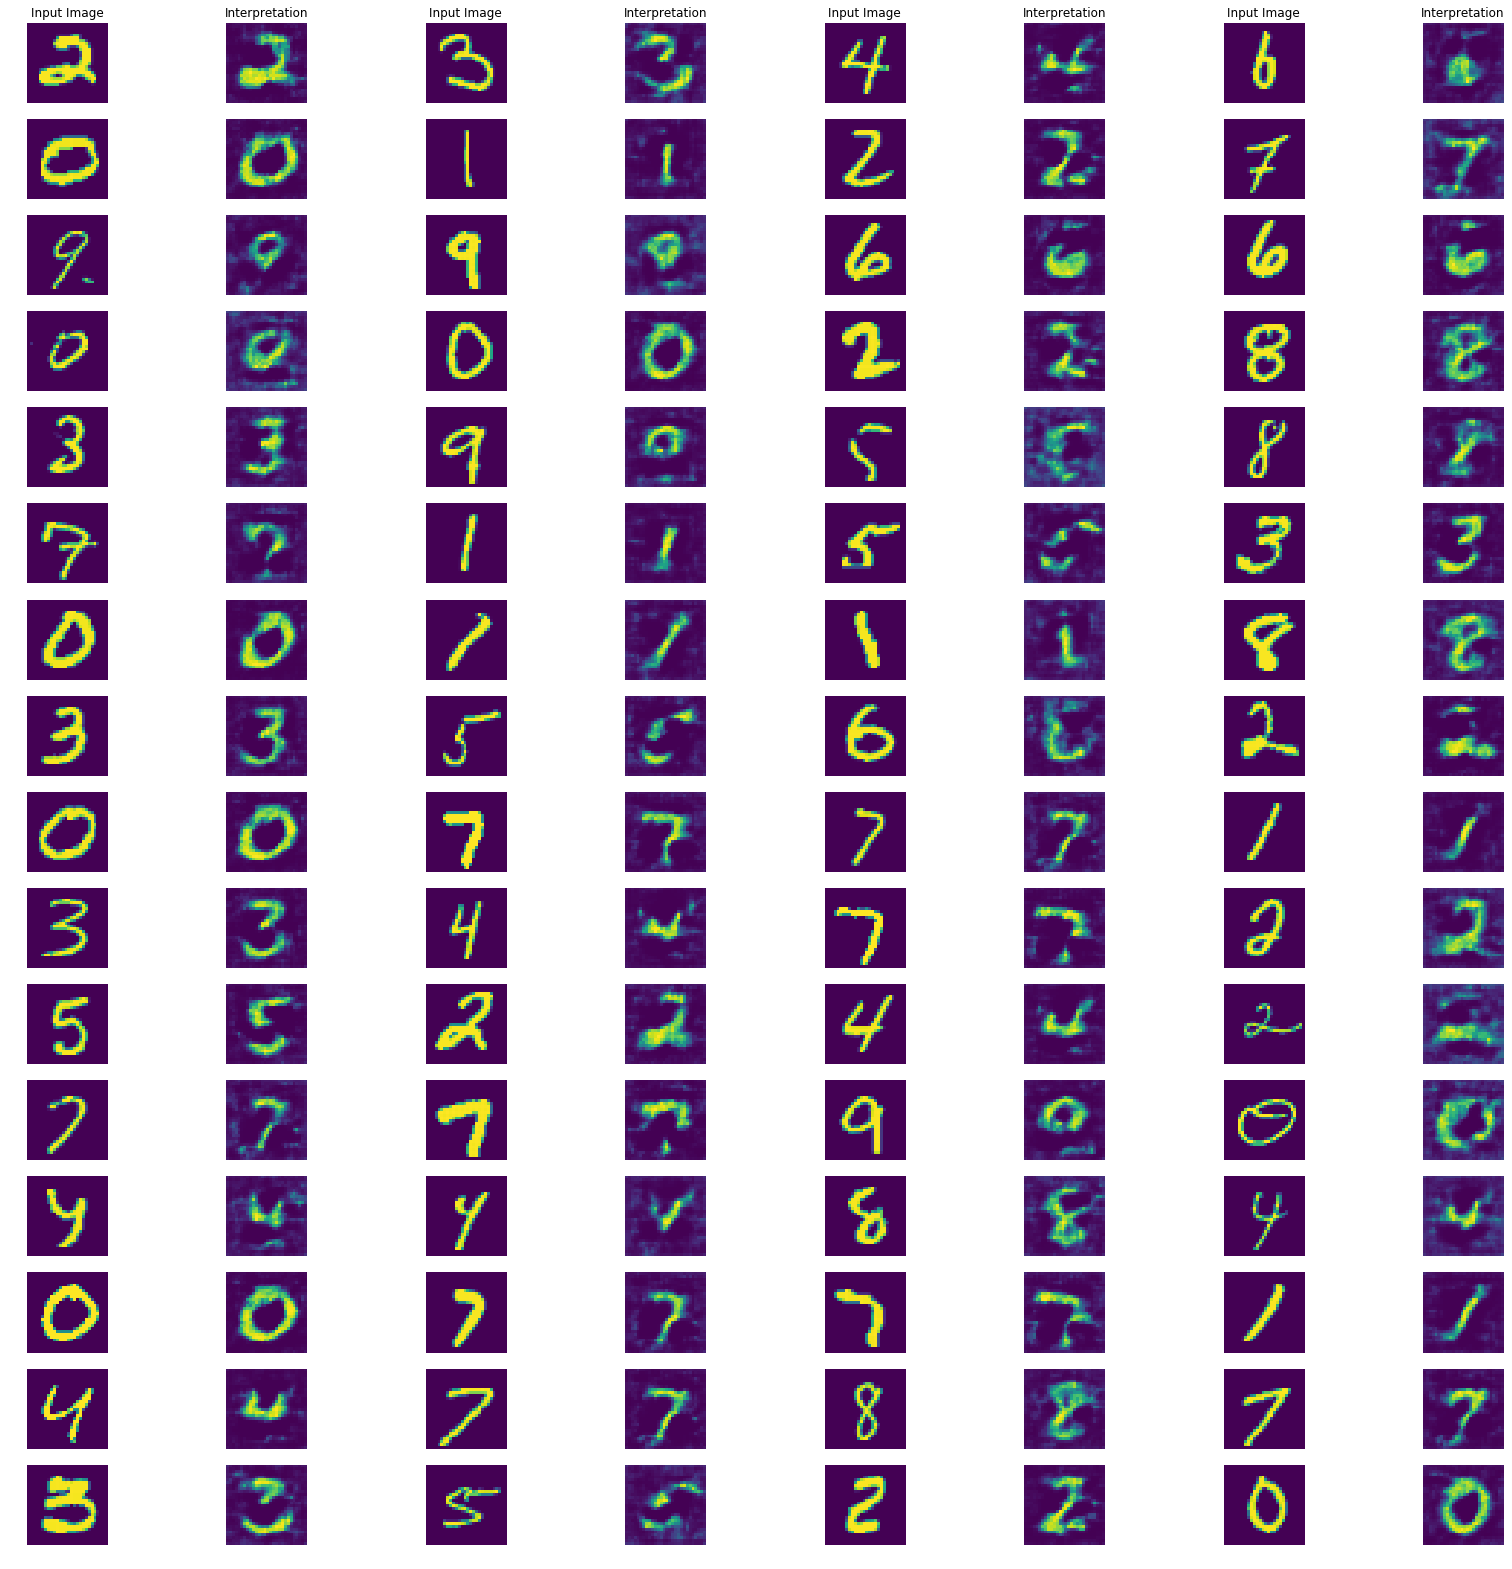

<Figure size 1440x1440 with 0 Axes>

In [4]:
import numpy as np
fig, axs = plt.subplots(16, 8, figsize=(28,28))
axs[0, 0].set_title('Input Image')
axs[0, 2].set_title('Input Image')
axs[0, 4].set_title('Input Image')
axs[0, 6].set_title('Input Image')
axs[0, 1].set_title('Interpretation')
axs[0, 3].set_title('Interpretation')
axs[0, 5].set_title('Interpretation')
axs[0, 7].set_title('Interpretation')

fig= plt.figure(figsize=(20, 20))

for j in range(0,4):
    for i in range(0,16):
        tests_figs = tests[i+j*16].reshape((28,28))
        axs[i, 2*j].imshow(tests_figs)
        axs[i, 2*j].axis('off')

        
for j in range(0,4):
    for i in range(0,16):
        interprets_figs = interprets[i+j*16].reshape((28,28))
        axs[i, 2*j+1].imshow(interprets_figs)
        axs[i, 2*j+1].axis('off')        
plt.show()